# Students' Academic Performance Prediction
----------

[Data Provenance](https://www.kaggle.com/aljarah/xAPI-Edu-Data)

The feature are classified into three major categories.

1. Demographic features such as gender and nationality. (성별, 국적 등 인구통계학적 특징)
   
2. Academic background features such as educational stage, grade Level and section. (학력단계, 학년수준, 섹션 등 학력적 특징)
    
3. Behavioral features such as raised hand on class, opening resources, answering survey by parents, and school satisfaction. (수업에서 손을 드는 것과 같은 개방적 자원, 학부모의 답변조사, 학교만족도)

---
**Data Content**
- gender: 학생의 성별 (M: 남성, F: 여성)
- NationaliTy: 학생의 국적
- PlaceofBirth: 학생의 출신지
- StageID: 학생이 다니는 학교 (초,중,고)
- GradeID: 학생의 학년 (G-01~12)
- SectionID: 학생이 속한 반 이름 (A, B, C)
- Topic: 수강한 과목
- Semester: 수강한 학기 (1학기/2학기)
- Relation: 주 보호자와 학생의 관계 (mom, father)
- raisedhands: 학생이 수업 중 손을 든 횟수 (0~100)
- VisITedResources: 학생이 과정 내용을 방문한 횟수 (0~100)
- AnnouncementsView : 학생이 과목 공지를 확인한 횟수 (0~100)
- Discussion: 학생이 토론 그룹에 참여한 횟수 (0~100)
- ParentAnsweringSurvey: 부모가 학교 설문에 참여했는지 여부
- ParentschoolSatisfaction: 부모가 학교에 만족했는지 여부
- StudentAbscenceDays: 학생의 결석 횟수 (7회 이상/미만)
- Class: 학생의 성적 등급 (L: 낮음, M: 보통, H: 높음)
- 학생들은 총 성적/점수에 따라 분류
  - Low-level : interval includes values from 0 to 69
  - Middle-level : interval includes values from 70 to 89
  - High-level : interval includes values from 90-100
        
---

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc, \
    PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve, average_precision_score

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # silence trial results and parameters
from functools import partial
import os
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
# import matplotlib as mpl
# plt.rcParams['font.family'] = 'AppleGothic' # matplotlib 그래프 한글 깨짐 방지
# mpl.rcParams['axes.unicode_minus'] = False # matplotlib 마이너스 기호 깨짐 방지

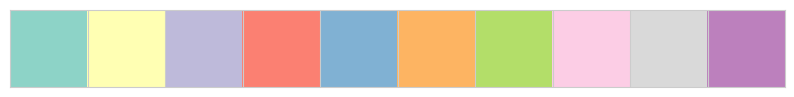

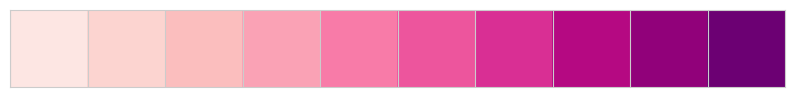

In [2]:
# 낮은값, 높은값 팔레트
diverging_colors = sns.color_palette("RdBu", 10)
sns.palplot(diverging_colors)
# 범주형 팔레트
qualitative_colors = sns.color_palette("Set3", 10)
sns.palplot(qualitative_colors)
# 등급 팔레트
sequential_colors = sns.color_palette("RdPu", 10)
sns.palplot(sequential_colors)

## Reading Data

In [3]:
df = pd.read_csv('./xAPI-Edu-Data.csv')

display(df.head())
print("-"*85)
display(df.info())
print("-"*85)
display(df.describe().T)
print("-"*85)
display(df.describe(include='object').T)

gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
0          20                   Yes                     Good   
1          25                   Yes                     Good   
2          30                    No                      Bad   
3          35                    No                      Bad   
4          50                    No                      Bad   

  StudentAbsenceDays Class  
0            Under-7     M  
1            Under-7     M  
2            Above-7     L  
3            Above-7     L  
4            Above-7     M

-------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 

None

-------------------------------------------------------------------------------------


count       mean        std  min    25%   50%   75%    max
raisedhands        480.0  46.775000  30.779223  0.0  15.75  50.0  75.0  100.0
VisITedResources   480.0  54.797917  33.080007  0.0  20.00  65.0  84.0   99.0
AnnouncementsView  480.0  37.918750  26.611244  0.0  14.00  33.0  58.0   98.0
Discussion         480.0  43.283333  27.637735  1.0  20.00  39.0  70.0   99.0

-------------------------------------------------------------------------------------


count unique           top freq
gender                     480      2             M  305
NationalITy                480     14            KW  179
PlaceofBirth               480     14        KuwaIT  180
StageID                    480      3  MiddleSchool  248
GradeID                    480     10          G-02  147
SectionID                  480      3             A  283
Topic                      480     12            IT   95
Semester                   480      2             F  245
Relation                   480      2        Father  283
ParentAnsweringSurvey      480      2           Yes  270
ParentschoolSatisfaction   480      2          Good  292
StudentAbsenceDays         480      2       Under-7  289
Class                      480      3             M  211

In [4]:
# 중복 의심 데이터 인덱스
df[df.duplicated() == True]

gender NationalITy PlaceofBirth     StageID GradeID SectionID   Topic  \
326      M      Jordan       Jordan  lowerlevel    G-02         A  French   
327      M      Jordan       Jordan  lowerlevel    G-02         A  French   

    Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
326        F   Father           10                15                 10   
327        S   Father           30                10                 20   

     Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
326          21                    No                      Bad   
327           5                    No                      Bad   

    StudentAbsenceDays Class  
326            Above-7     L  
327            Above-7     L

---

## EDA

In [5]:
# AutoViz - 데이터 전처리 및 시각화를 자동화할 수 있음

# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

# save_plot_dir = './'

# dft = AV.AutoViz(
#     filename="", # 데이터프레임 사용시 ("")입력
#     sep=",", 
#     depVar="Class", # target variable
#     dfte=df, # input dataframe
#     header=0, # the row number of header row
#     verbose=2, #0: 주피터노트북 표시(최소), 1: 주피터노트북 표시, 2: 로컬에 저장
#     lowess=True, # nice for small dataset, don't use this for large dataset(over 100,000 rows)
#     chart_format="png", # save format
#     max_rows_analyzed=500,
#     max_cols_analyzed=20,
#     save_plot_dir=save_plot_dir # 저장할 경로
# )

In [6]:
cat_cols = df.select_dtypes(include='object').columns[:-1] # without target(Class)
num_cols = df.select_dtypes(exclude='object').columns

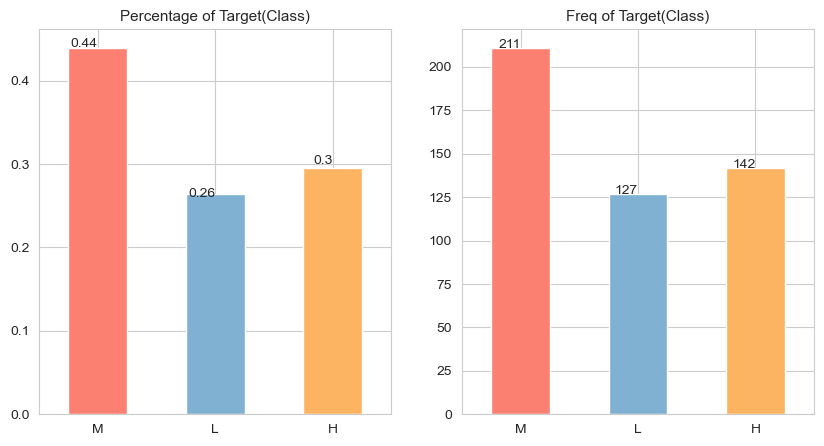

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df.Class.value_counts(normalize=True, sort=False).plot.bar(color=qualitative_colors[3:])
plt.title('Percentage of Target(Class)', fontsize=11)
plt.xticks(rotation=0)
for idx, value in enumerate(df.Class.value_counts(normalize=True, sort=False).round(2).values):
    plt.text(idx, value, str(value), va='baseline', ha='right')
    
plt.subplot(1, 2, 2)
df.Class.value_counts(sort=False).plot.bar(color=qualitative_colors[3:])
plt.title('Freq of Target(Class)', fontsize=11)
plt.xticks(rotation=0)
for idx, value in enumerate(df.Class.value_counts(sort=False).round(2).values):
    plt.text(idx, value, str(value), va='baseline', ha='right')

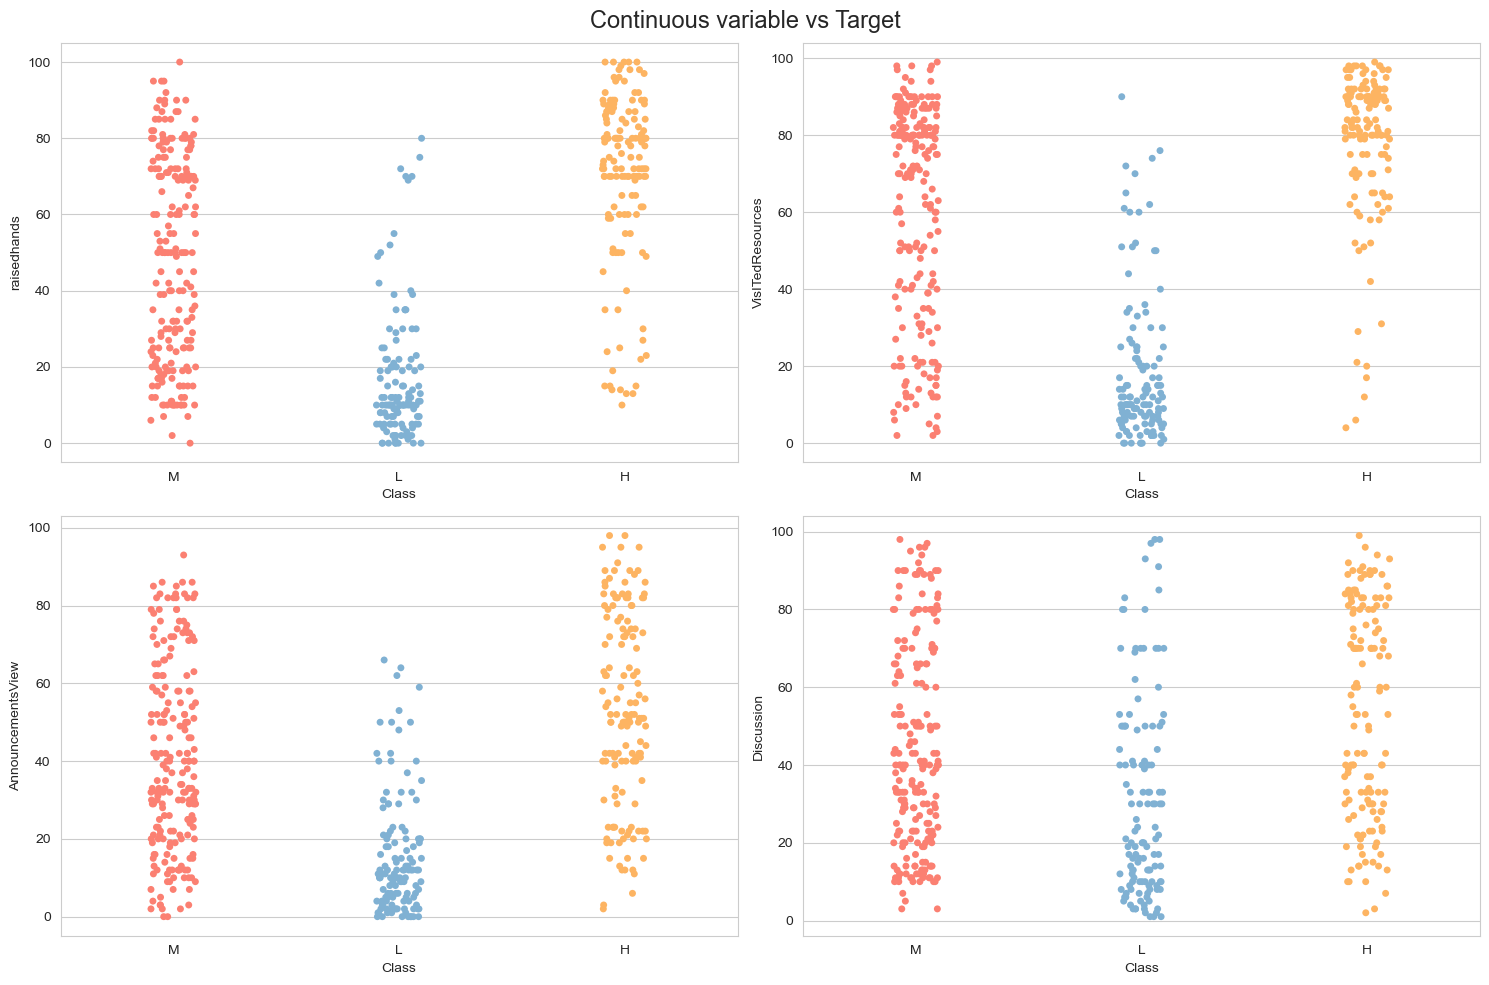

In [8]:
plt.figure(figsize=(15, 10))
j = 1

for col in num_cols:
    plt.subplot(2, 2, j)
    sns.stripplot(x='Class', y=col, data=df, palette=qualitative_colors[3:])
    plt.xticks(rotation=0)
    j += 1
plt.suptitle('Continuous variable vs Target', fontsize=17)
plt.tight_layout()
plt.show()

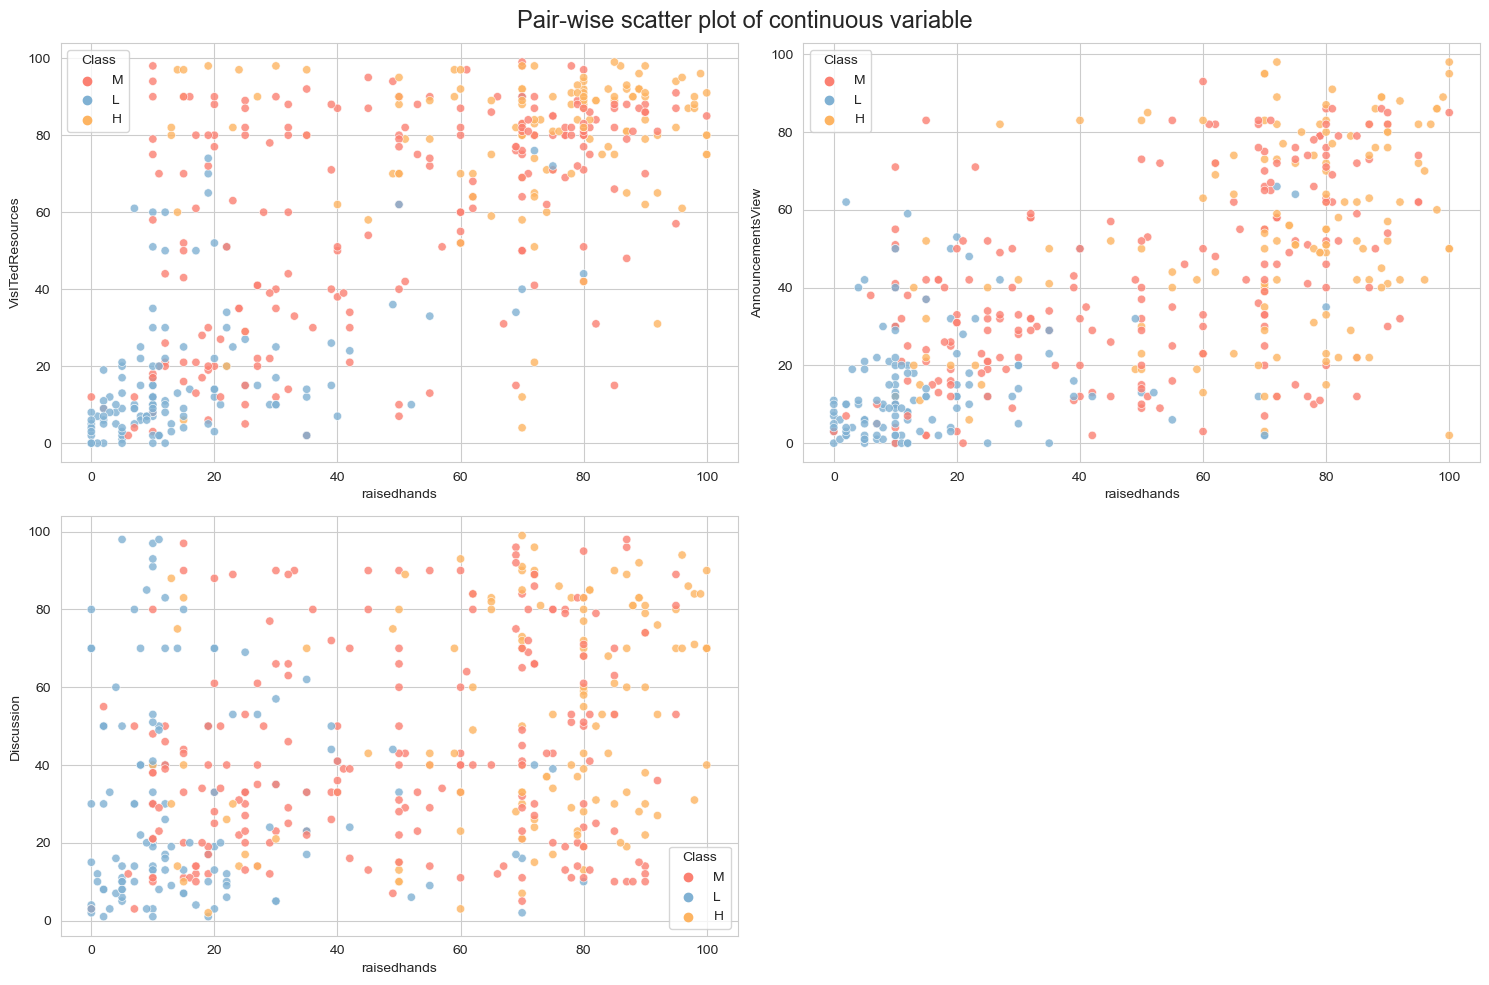

In [9]:
plt.figure(figsize=(15, 10))
j = 1

for col in num_cols[1:]:
    plt.subplot(2, 2, j)
    sns.scatterplot(x=df.raisedhands, y=df[col], hue=df.Class, alpha=.8, palette=qualitative_colors[3:])
    j += 1
plt.suptitle('Pair-wise scatter plot of continuous variable', fontsize=17)
plt.tight_layout()
plt.show()

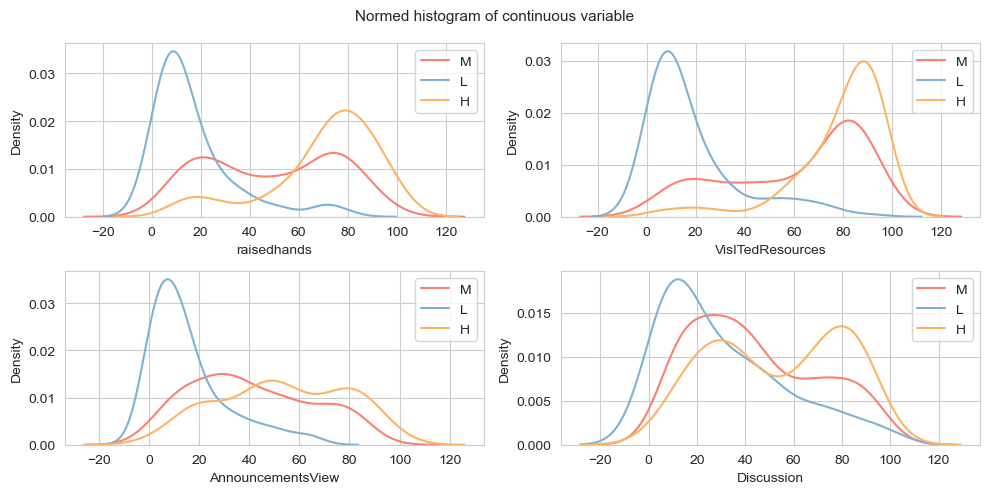

In [10]:
fig = plt.figure(figsize=(10, 5))
j = 1

for i in num_cols:
    plt.subplot(2, 2, j)
    sns.distplot(df[df.Class == 'M'][i], color=qualitative_colors[3], hist=False)
    sns.distplot(df[df.Class == 'L'][i], color=qualitative_colors[4], hist=False)
    sns.distplot(df[df.Class == 'H'][i], color=qualitative_colors[5], hist=False)
    plt.legend(('M', 'L', 'H'))
    j += 1

plt.suptitle('Normed histogram of continuous variable', fontsize=11)
plt.tight_layout()
plt.show()

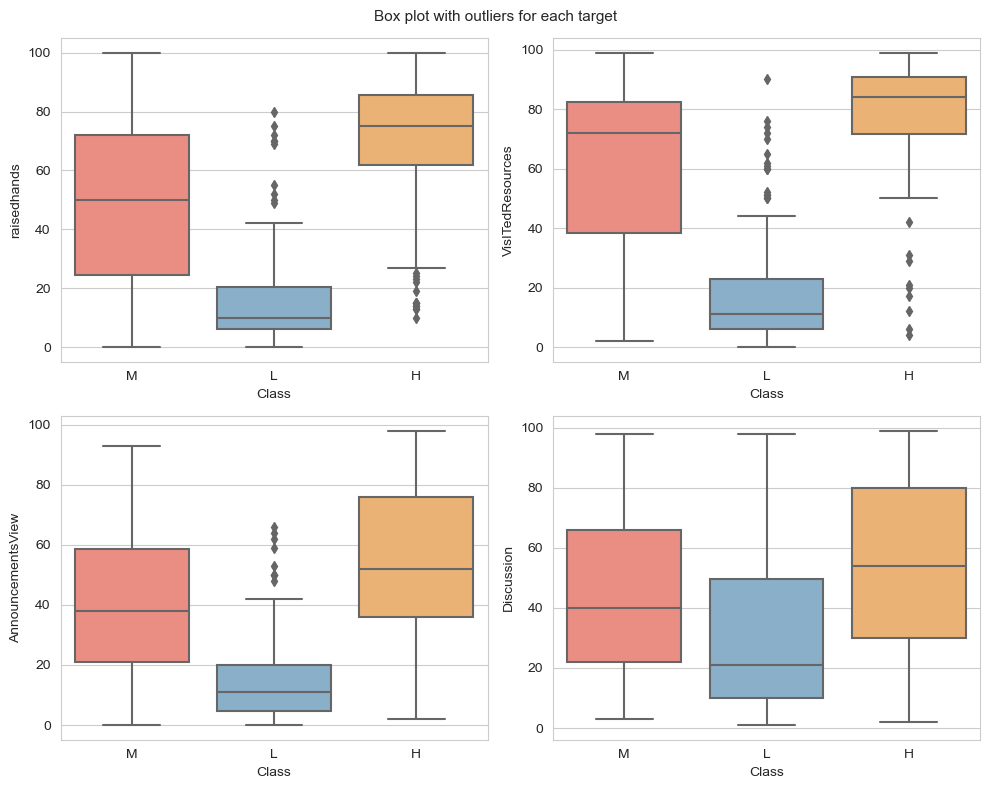

In [11]:
fig = plt.figure(figsize=(10, 8))
j = 1

for i in num_cols:
    plt.subplot(2, 2, j)
    sns.boxplot(y=df[i], x=df['Class'], palette=qualitative_colors[3:])
    j += 1
plt.suptitle('Box plot with outliers for each target', fontsize=11)
plt.tight_layout()
plt.show()

<AxesSubplot:>

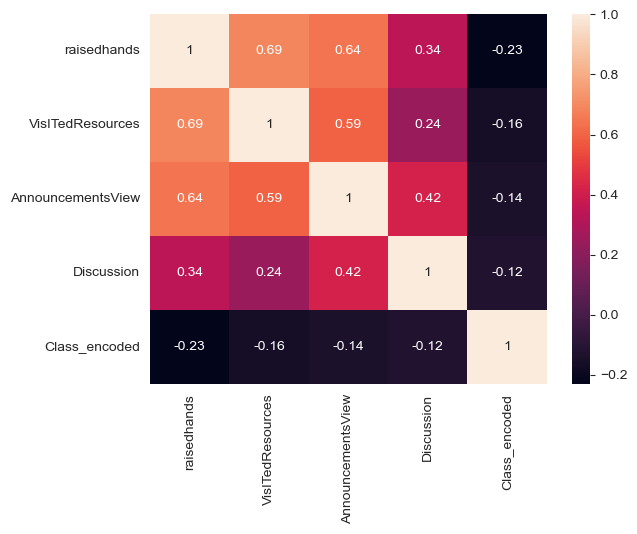

In [12]:
temp_dict = {'H' : 0, 'L' : 1, 'M' : 2} # target encoded
temp = df.copy()
temp['Class_encoded'] = temp['Class'].map(temp_dict)

sns.heatmap(data=temp.corr(), annot=True)

- raisedhands는 VisITedResources와 AnnouncementsView과 강한 상관관계가 있다. 
- VisITedResources는 AnnouncementsView와 뚜렷한 상관관계가 있다.

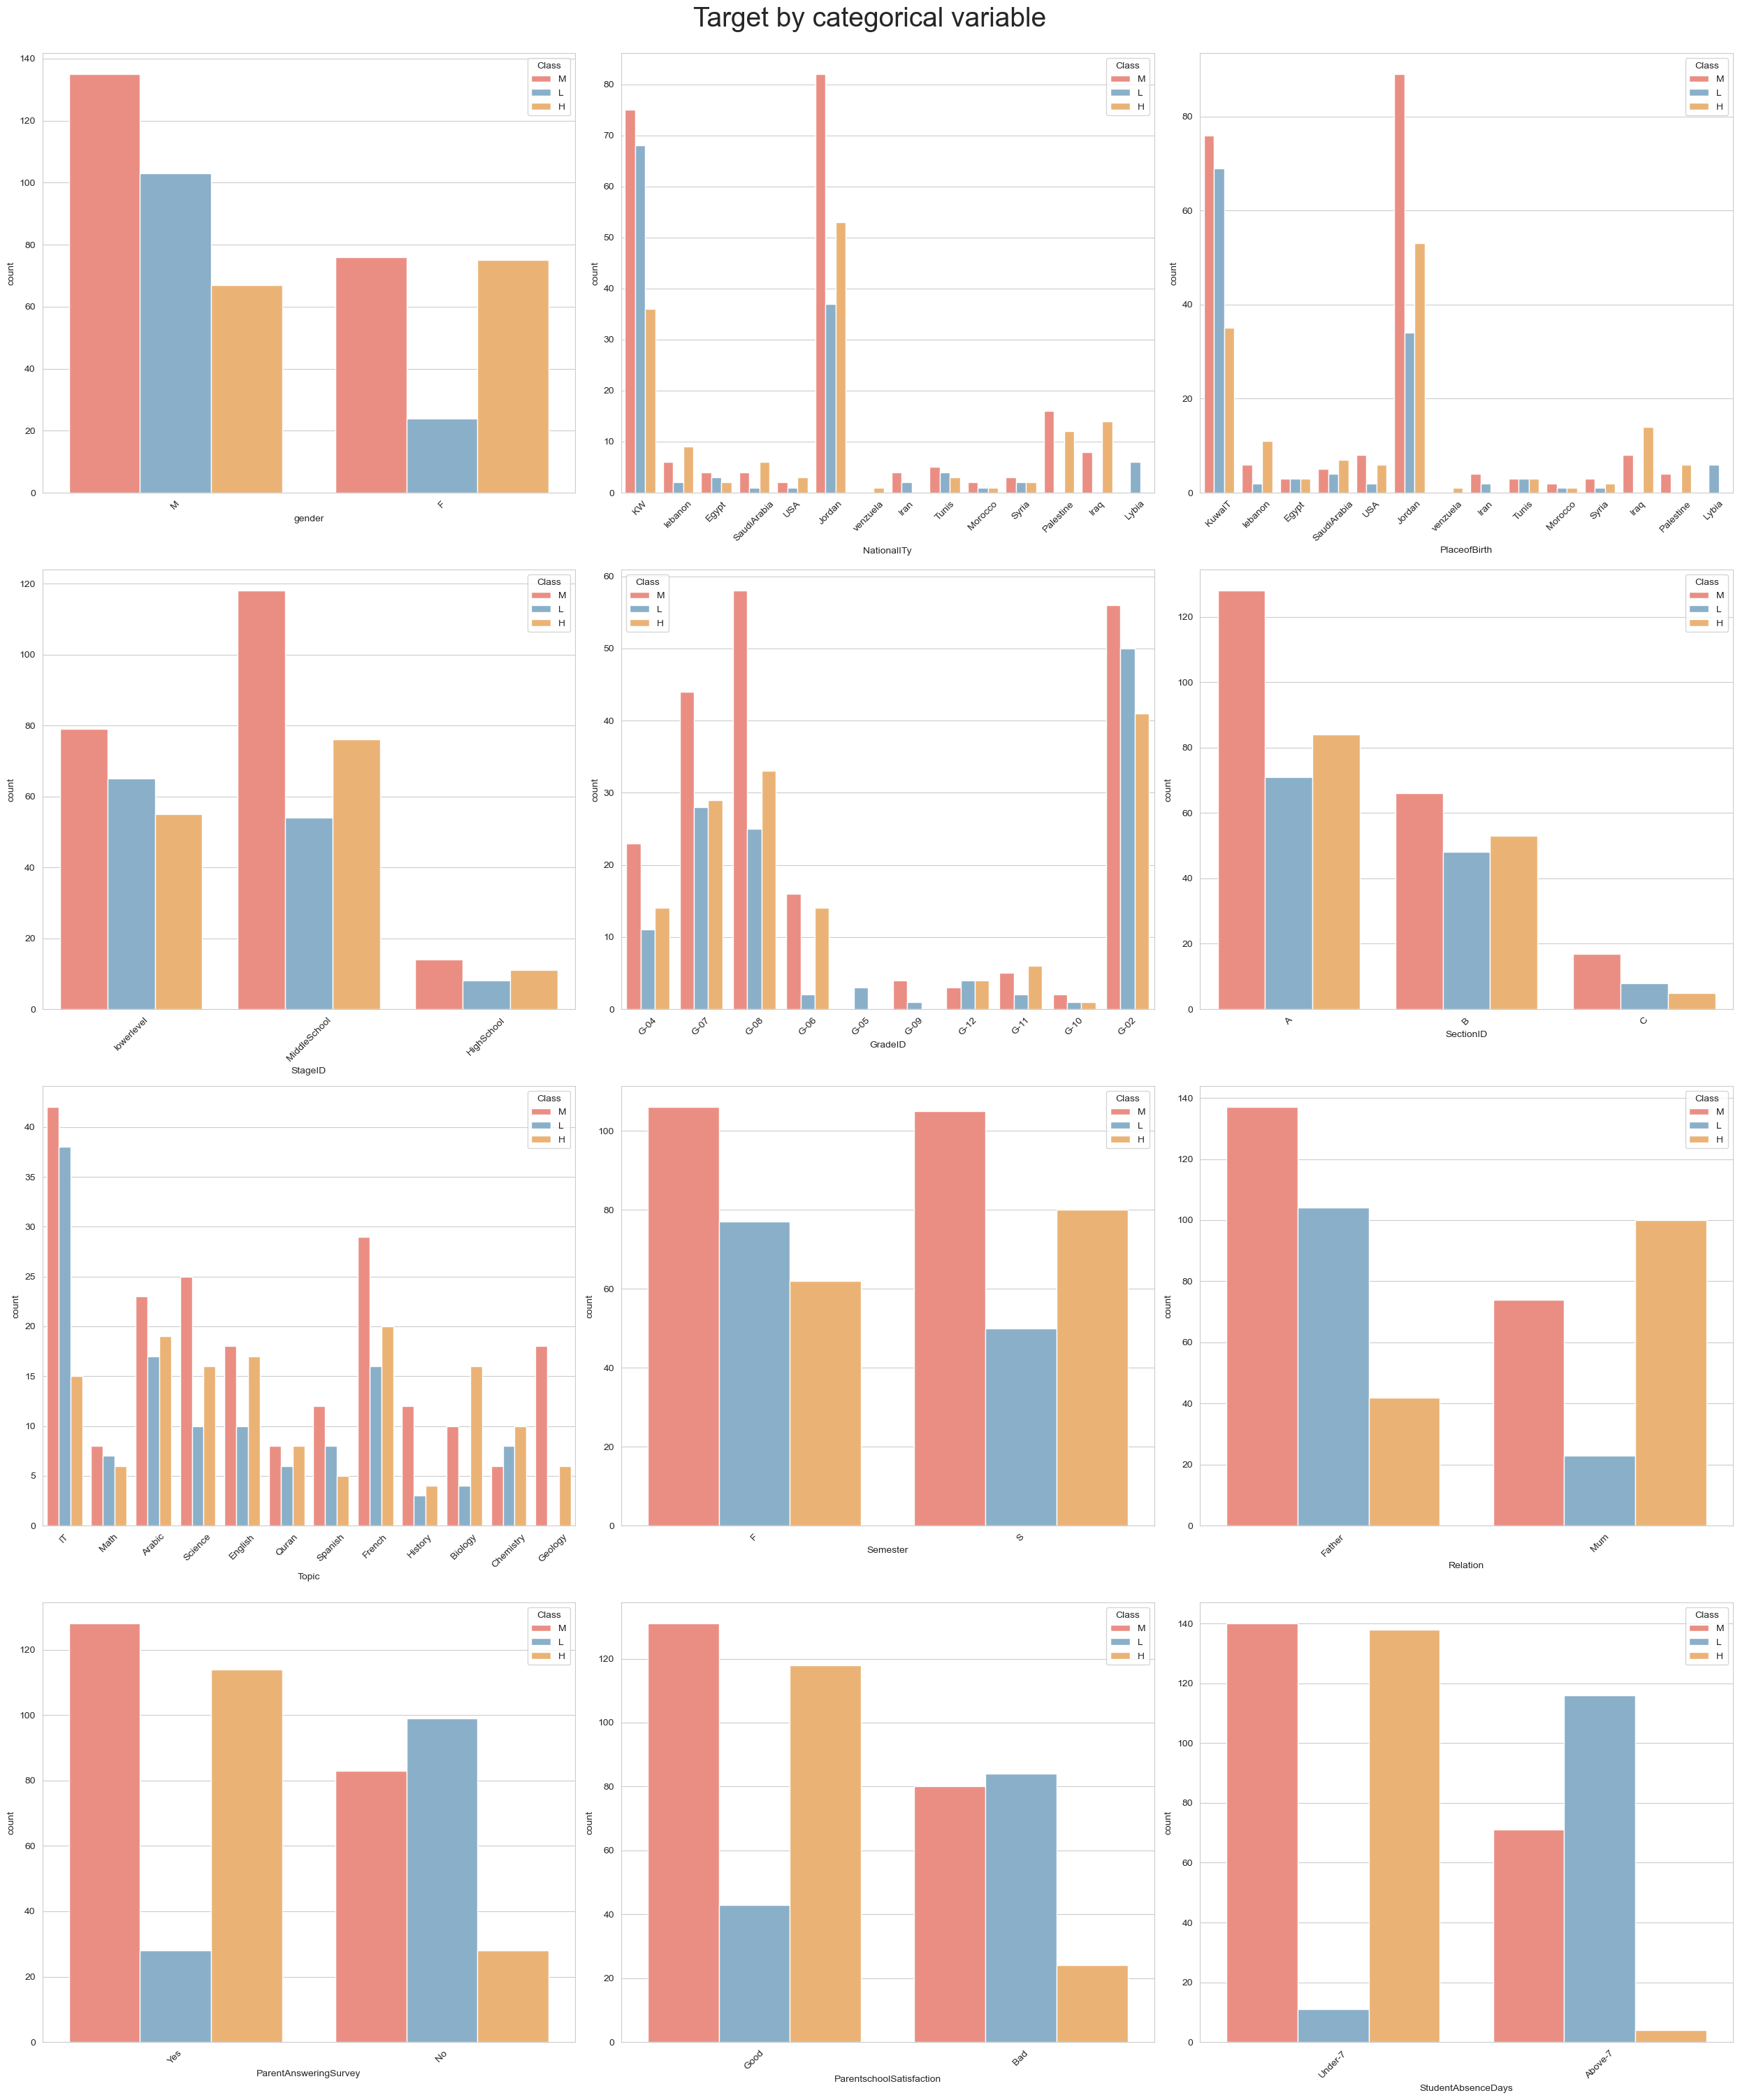

In [13]:
fig = plt.figure(figsize=(25, 30))
j = 1

for i in cat_cols:
    plt.subplot(4, 3, j)
    sns.countplot(x=df[i], hue=df['Class'], palette=qualitative_colors[3:])
    plt.xticks(rotation=45)
    j += 1
    
plt.suptitle('Target by categorical variable', fontsize=28, y=1)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Gender by target')

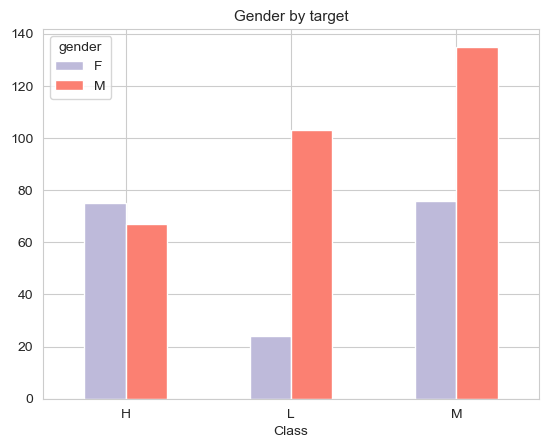

In [14]:
pd.crosstab(index=df.Class, columns=df.gender, values=df.gender, aggfunc='count').plot.bar(rot=0, color=qualitative_colors[2:])
plt.title('Gender by target', fontsize=11)

- Class(H)는 여학생이 더 많다.

In [15]:
plt.figure(figsize=(15, 10))
j = 1

for col in num_cols:
    plt.subplot(2, 2, j)
    temp_df = df.groupby(['Class', 'gender'])[col].mean().reset_index()
    sns.barplot(x='Class', y=col, data=temp_df, hue='gender', palette=qualitative_colors[2:])
    plt.axhline(y=df.groupby(['Class', 'gender'])[col].mean().mean(), color='red', linestyle='--') # mean by Class
    plt.title(f'{col} by Class')
    plt.xticks(rotation=0)
    j += 1

plt.suptitle('Average continuous variable by Target&Gender', fontsize=15)
plt.tight_layout()
plt.show()

- Class(H) gender(F,여학생)의 VisITedResources 평균은 남학생보다 조금 높다.
- Class(L) 여학생의 Discussion 평균은 Class(M)보다 높다.

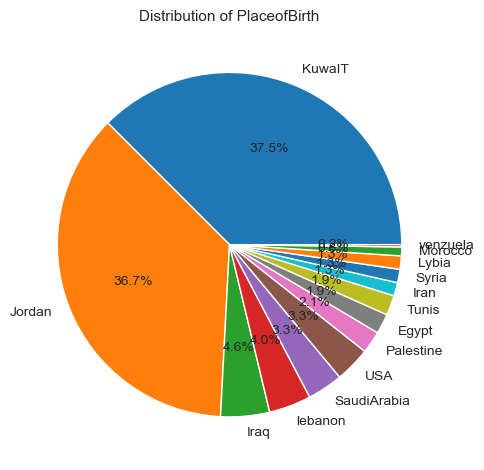

In [16]:
plt.pie(df.PlaceofBirth.value_counts(), labels=df.PlaceofBirth.value_counts().index, autopct='%.1f%%')
plt.title('Distribution of PlaceofBirth', fontsize=11)
plt.tight_layout()
plt.show()

- 대부분의 학생은 KuwaIT(쿠웨이트), Jordan(요르단) 출신이다. 

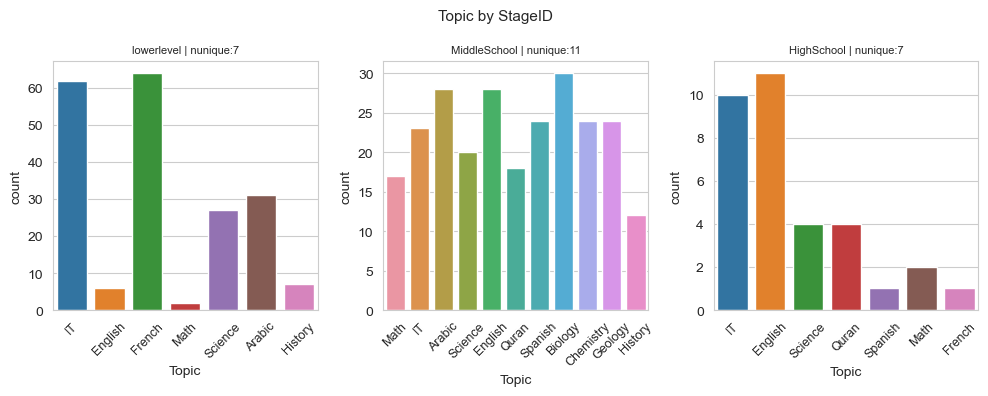

In [17]:
L_stage = df[df.StageID == 'lowerlevel']
M_stage = df[df.StageID == 'MiddleSchool']
H_stage = df[df.StageID == 'HighSchool']

plt.figure(figsize=(10, 4))
j = 1

for i in [L_stage, M_stage, H_stage]:
    plt.subplot(1, 3, j)
    sns.countplot(x=i['Topic'])
    plt.xticks(rotation=45, fontsize=9)
    plt.title(f'{i.StageID.unique()[0]} | nunique:{i.Topic.nunique()}', fontsize=8)
    j += 1

plt.suptitle('Topic by StageID', fontsize=11)
plt.tight_layout()
plt.show()

- StageID별 Topic의 개수가 다르다. MiddleSchool은 과목이 다양해서 크게 몇 과목에만 치우치지 않는다.
- French는 MiddleSchool에 없다.
- Arabic은 HighSchool에 없다.
    - 대부분의 학생이 쿠웨이트, 요르단 출신이라 어렸을 때부터 Arabic을 배우고 Quran(코란, 이슬람교의 경전) 과목을 Middle/HighSchool에서 수강하는 것 같다.

StageID       GradeID
lowerlevel    G-07         1
              G-05         3
              G-04        48
              G-02       147
MiddleSchool  G-08       116
              G-07       100
              G-06        32
HighSchool    G-12        11
              G-11        13
              G-10         4
              G-09         5
Name: gender, dtype: int64

----------------------------------------


Text(0.5, 1.0, 'StageID by GradeID')

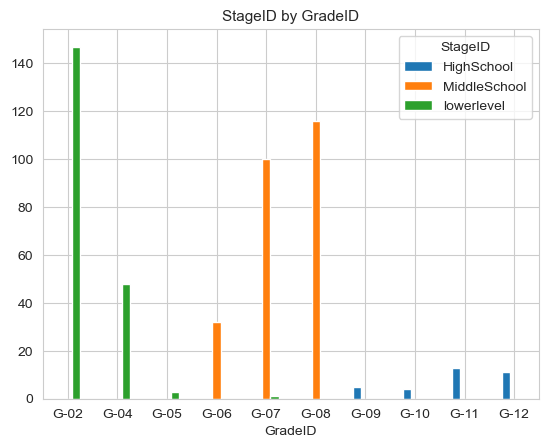

In [18]:
display(df.groupby(['StageID', 'GradeID']).count()['gender'].sort_index(ascending=False))
print("-"*40)
pd.crosstab(columns=df.StageID, index=df.GradeID, values=df.gender, aggfunc='count').plot.bar(rot=0)
plt.title("StageID by GradeID", fontsize=11)

- 같은 GradeID(G-07)가 다른 StageID(MiddleSchool)에도 있다.
- GradeID(G-02)학년 학생이 가장 많다.
    - 많이 수강한 Topic 3개(IT, French, Arabic)를 해당 학생들이 수강했다.

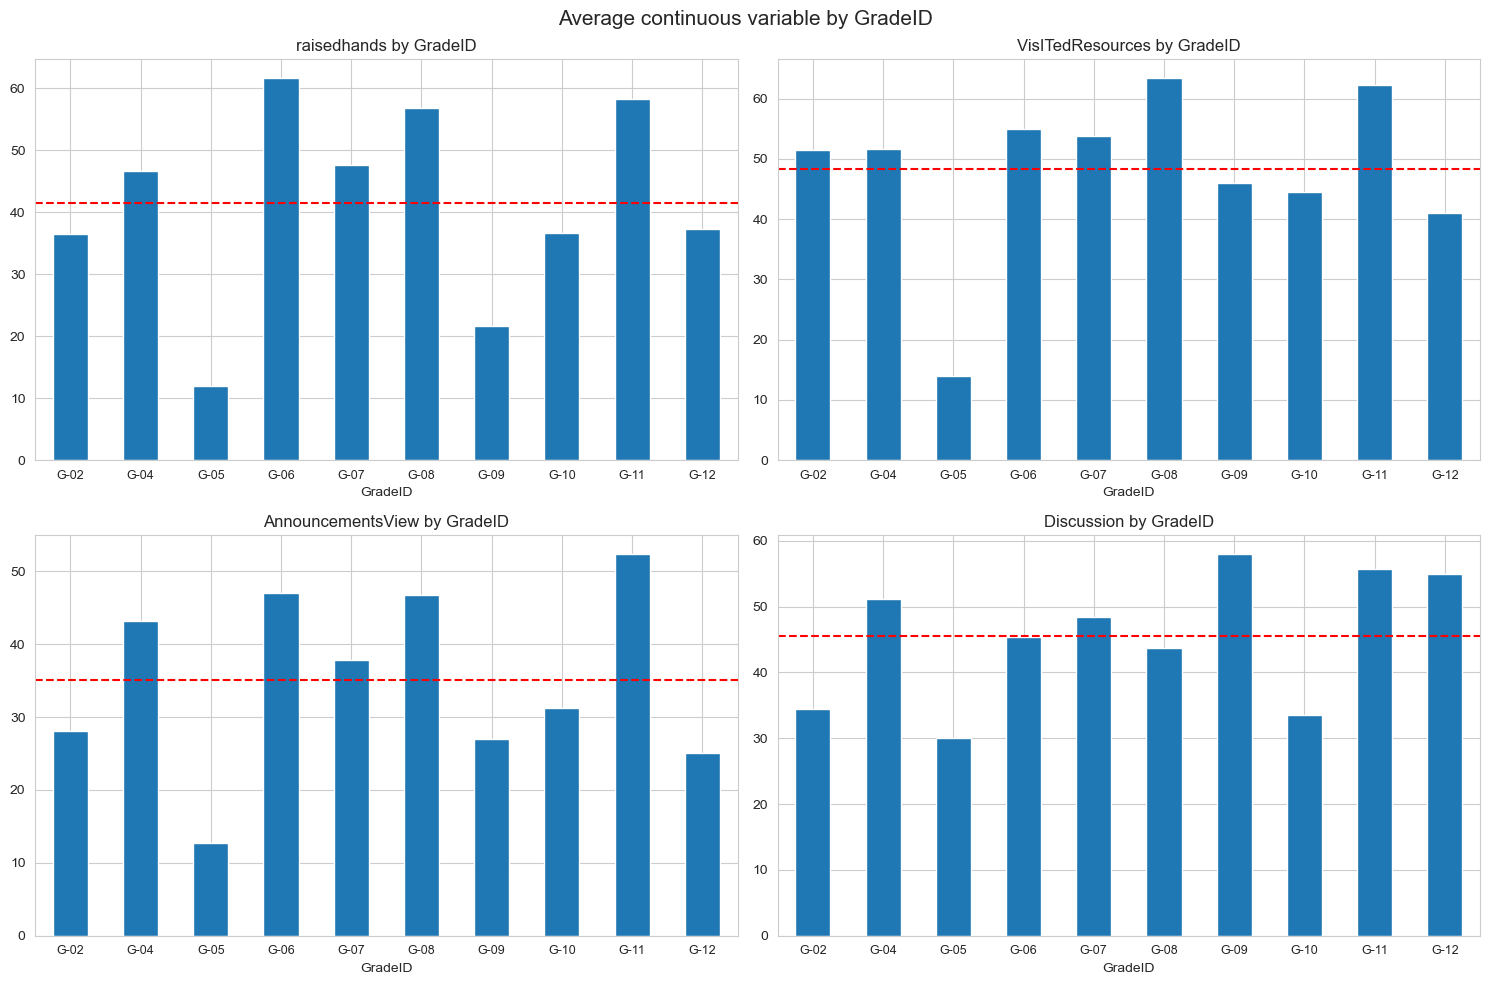

In [19]:
plt.figure(figsize=(15, 10))
j = 1

for col in num_cols:
    plt.subplot(2, 2, j)
    df.groupby('GradeID')[col].mean().plot.bar()
    plt.axhline(y=df.groupby('GradeID')[col].mean().mean(), color='red', linestyle="--") # Average liune
    plt.title(f'{col} by GradeID')
    plt.xticks(rotation=0, fontsize=9)
    j += 1

plt.suptitle('Average continuous variable by GradeID', fontsize=15)
plt.tight_layout()
plt.show()

- GradeID(G-05)학년 학생은 3명밖에 없어서 전체적으로 낮아보인다.
    - GradeID(G-05)의 ParentAnsweringSurvey는 No만 있다.
- GradeID(G-11)학년 학생은 13명이지만 전체적으로 높다. (평균 이상)

G-02    15
G-08    15
Name: GradeID, dtype: int64

------------------------------


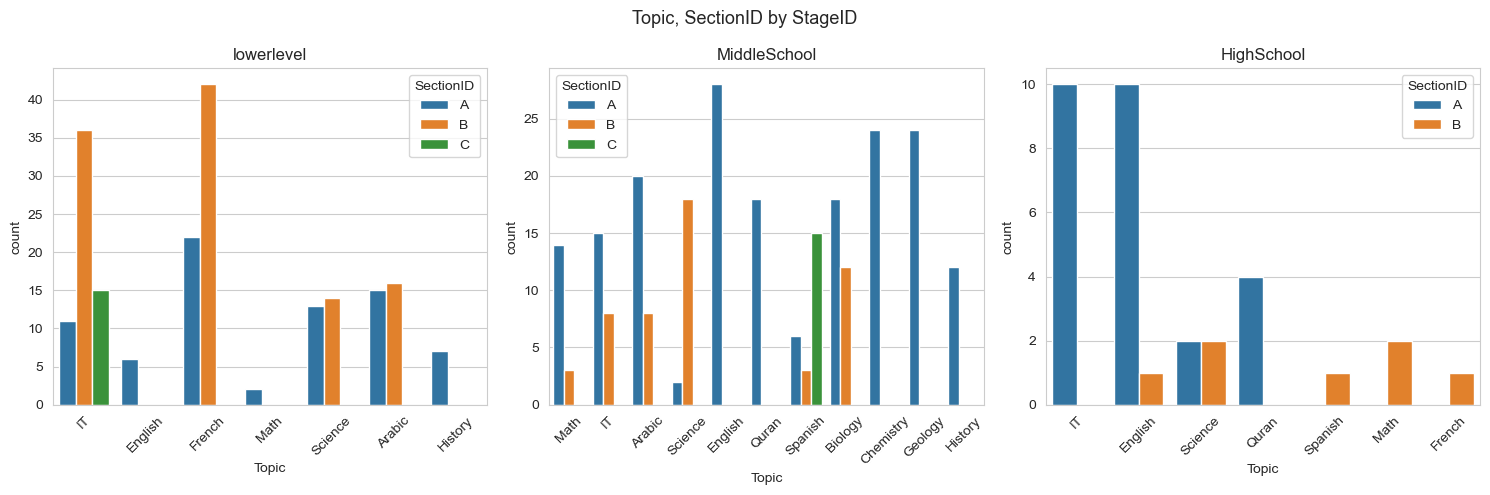

In [20]:
display(df[df.SectionID == 'C']['GradeID'].value_counts())
print("-"*30)

plt.figure(figsize=(15, 5))
j = 1

for i in [L_stage, M_stage, H_stage]:
    plt.subplot(1, 3, j)
    sns.countplot(x=i['Topic'], hue=i['SectionID'])
    plt.xticks(rotation=45)
    plt.title(i.StageID.unique()[0])
    j += 1
    
plt.suptitle('Topic, SectionID by StageID', fontsize=13)
plt.tight_layout()
plt.show()

- Section(C)반은 GradeID(G-02, G-08)학년만 있고, Topic(IT와 Spanish)을 수강한다.

In [21]:
plt.figure(figsize=(15, 10))
j = 1

for col in num_cols:
    plt.subplot(2, 2, j)
    df.groupby('Topic')[col].mean().plot.bar()
    plt.axhline(y=df.groupby('Topic')[col].mean().mean(), color='red', linestyle="--") # Average by GradeID
    plt.title(f'{col} by Topic')
    plt.xticks(rotation=45)
    j += 1

plt.suptitle('Average continuous variable by Topic', fontsize=15)
plt.tight_layout()
plt.show()

- Topic(Geology, Biology, History)는 평균보다 높다.

In [22]:
pd.crosstab(index=df.Semester, columns=df.Topic, values=df.gender, aggfunc='count', normalize='columns').round(4)

Topic     Arabic  Biology  Chemistry  English  French  Geology  History  \
Semester                                                                  
F         0.3051      0.5        0.5   0.6222  0.3385      0.5   0.3158   
S         0.6949      0.5        0.5   0.3778  0.6615      0.5   0.6842   

Topic         IT    Math   Quran  Science  Spanish  
Semester                                            
F         0.9474  0.7619  0.3636   0.3529      0.0  
S         0.0526  0.2381  0.6364   0.6471      1.0

- Topic(IT)는 Semester(F)학기에 90명(94.7%) 수강했다.
- Topic(Spanish)는 Semester(S)학기에만 수강했다.

In [23]:
pd.crosstab(index=[df.Class, df.Relation], columns=df.ParentschoolSatisfaction, values=df.gender, aggfunc='count', normalize='index').round(4)

ParentschoolSatisfaction     Bad    Good
Class Relation                          
H     Father              0.1905  0.8095
      Mum                 0.1600  0.8400
L     Father              0.7500  0.2500
      Mum                 0.2609  0.7391
M     Father              0.4234  0.5766
      Mum                 0.2973  0.7027

- Class(L)에 대한 Relation(Mum)의 ParentschoolSatisfaction은 17명(73%)이 Good이다.

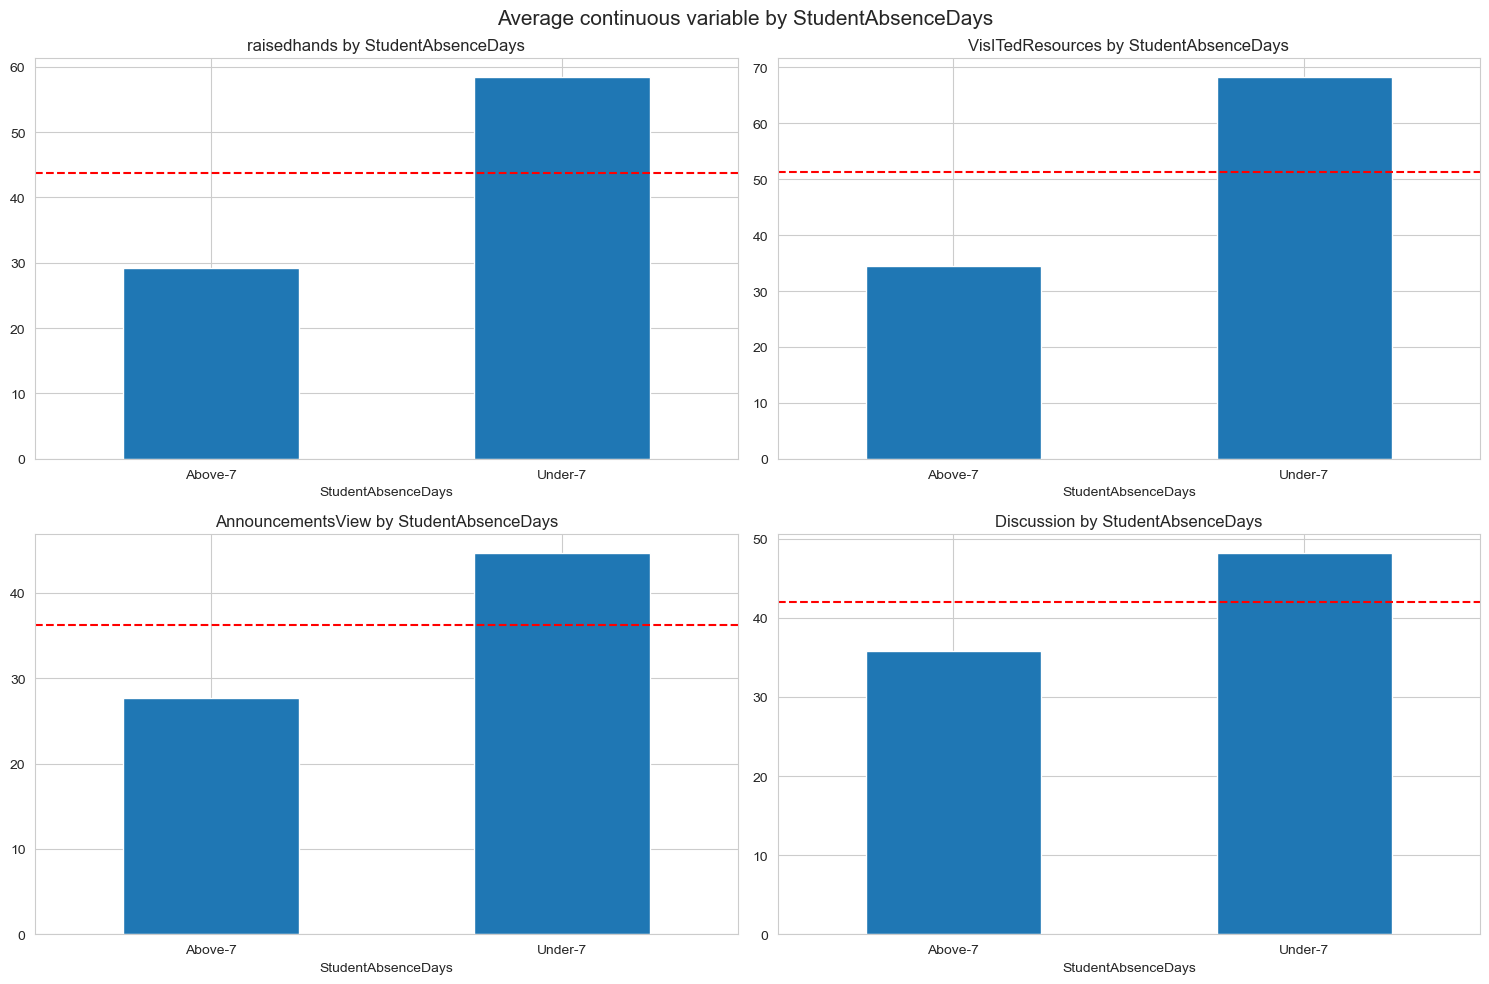

In [24]:
plt.figure(figsize=(15, 10))
j = 1

for col in num_cols:
    plt.subplot(2, 2, j)
    df.groupby('StudentAbsenceDays')[col].mean().plot.bar()
    plt.axhline(y=df.groupby('StudentAbsenceDays')[col].mean().mean(), color='red', linestyle='--') # Average by StudentAbsenceDays
    plt.title(f'{col} by StudentAbsenceDays')
    plt.xticks(rotation=0)
    j += 1

plt.suptitle('Average continuous variable by StudentAbsenceDays', fontsize=15)
plt.tight_layout()
plt.show()

- StudentAbsenceDays(Under-7)인 경우 평균보다 높다.

## Feature Engineering

In [25]:
new_df = df.copy()

encoder = LabelEncoder()
new_df['Class_LBE'] = encoder.fit_transform(new_df.Class) # print(encoder.classes_) -> H(0), L(1), M(2)

new_df = new_df.drop(columns=['Class', 'PlaceofBirth']).rename(columns={'Class_LBE' : 'Class'})
new_df

gender NationalITy       StageID GradeID SectionID      Topic Semester  \
0        M          KW    lowerlevel    G-04         A         IT        F   
1        M          KW    lowerlevel    G-04         A         IT        F   
2        M          KW    lowerlevel    G-04         A         IT        F   
3        M          KW    lowerlevel    G-04         A         IT        F   
4        M          KW    lowerlevel    G-04         A         IT        F   
..     ...         ...           ...     ...       ...        ...      ...   
475      F      Jordan  MiddleSchool    G-08         A  Chemistry        S   
476      F      Jordan  MiddleSchool    G-08         A    Geology        F   
477      F      Jordan  MiddleSchool    G-08         A    Geology        S   
478      F      Jordan  MiddleSchool    G-08         A    History        F   
479      F      Jordan  MiddleSchool    G-08         A    History        S   

    Relation  raisedhands  VisITedResources  AnnouncementsView  Discussion  \
0     Father           15                16                  2          20   
1     Father           20                20                  3          25   
2     Father           10                 7                  0          30   
3     Father           30                25                  5          35   
4     Father           40                50                 12          50   
..       ...          ...               ...                ...         ...   
475   Father            5                 4                  5           8   
476   Father           50                77                 14          28   
477   Father           55                74                 25          29   
478   Father           30                17                 14          57   
479   Father           35                14                 23          62   

    ParentAnsweringSurvey ParentschoolSatisfaction StudentAbsenceDays  Class  
0                     Yes                     Good            Under-7      2  
1                     Yes                     Good            Under-7      2  
2                      No                      Bad            Above-7      1  
3                      No                      Bad            Above-7      1  
4                      No                      Bad            Above-7      2  
..                    ...                      ...                ...    ...  
475                    No                      Bad            Above-7      1  
476                    No                      Bad            Under-7      2  
477                    No                      Bad            Under-7      2  
478                    No                      Bad            Above-7      1  
479                    No                      Bad            Above-7      1  

[480 rows x 16 columns]

In [26]:
temp_col = new_df.select_dtypes(include='object').columns

df_OHE = pd.get_dummies(data=new_df, columns=temp_col, drop_first=True)
df_OHE

raisedhands  VisITedResources  AnnouncementsView  Discussion  Class  \
0             15                16                  2          20      2   
1             20                20                  3          25      2   
2             10                 7                  0          30      1   
3             30                25                  5          35      1   
4             40                50                 12          50      2   
..           ...               ...                ...         ...    ...   
475            5                 4                  5           8      1   
476           50                77                 14          28      2   
477           55                74                 25          29      2   
478           30                17                 14          57      1   
479           35                14                 23          62      1   

     gender_M  NationalITy_Iran  NationalITy_Iraq  NationalITy_Jordan  \
0           1                 0                 0                   0   
1           1                 0                 0                   0   
2           1                 0                 0                   0   
3           1                 0                 0                   0   
4           1                 0                 0                   0   
..        ...               ...               ...                 ...   
475         0                 0                 0                   1   
476         0                 0                 0                   1   
477         0                 0                 0                   1   
478         0                 0                 0                   1   
479         0                 0                 0                   1   

     NationalITy_KW  ...  Topic_IT  Topic_Math  Topic_Quran  Topic_Science  \
0                 1  ...         1           0            0              0   
1                 1  ...         1           0            0              0   
2                 1  ...         1           0            0              0   
3                 1  ...         1           0            0              0   
4                 1  ...         1           0            0              0   
..              ...  ...       ...         ...          ...            ...   
475               0  ...         0           0            0              0   
476               0  ...         0           0            0              0   
477               0  ...         0           0            0              0   
478               0  ...         0           0            0              0   
479               0  ...         0           0            0              0   

     Topic_Spanish  Semester_S  Relation_Mum  ParentAnsweringSurvey_Yes  \
0                0           0             0                          1   
1                0           0             0                          1   
2                0           0             0                          0   
3                0           0             0                          0   
4                0           0             0                          0   
..             ...         ...           ...                        ...   
475              0           1             0                          0   
476              0           0             0                          0   
477              0           1             0                          0   
478              0           0             0                          0   
479              0           1             0                          0   

     ParentschoolSatisfaction_Good  StudentAbsenceDays_Under-7  
0                                1                           1  
1                                1                           1  
2                                0                           0  
3                                0                           0  
4                                0                  

In [27]:
X = df_OHE.drop(columns='Class')
y = df_OHE.Class

print(X.shape, y.shape)

(480, 47) (480,)


## ~~Feature Selection~~

In [28]:
# Feature selection - RFECV
rf = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(5),
              scoring='accuracy', verbose=2)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
print(f"Chose best features by rfecv: {X.columns[rfecv.support_]}")
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 fe

Fitting estimator with 2 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fea

## Train-test dataset split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(384, 47) (96, 47) (384,) (96,)


## Model Training


In [30]:
# confusion matrix visualization
def plot_cm(cm, title):
    ax = sns.heatmap(cm, annot=True, cmap=sequential_colors)
    
    ax.set_title(f'Confusion matrix: {title}')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['H', 'L', 'M'])
    ax.yaxis.set_ticklabels(['H', 'L', 'M'])
    
    plt.show()

Logistic Regression
- Train Accuracy: 0.8255 
- Test  Acuuracy: 0.7917 

              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.79      0.88      0.84        26
           2       0.80      0.77      0.79        48

    accuracy                           0.79        96
   macro avg       0.79      0.79      0.79        96
weighted avg       0.79      0.79      0.79        96

#################################################################


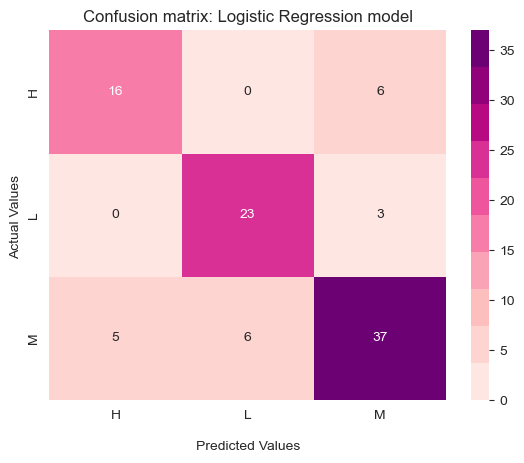

Gaussian Naive Bayes
- Train Accuracy: 0.5104 
- Test  Acuuracy: 0.4271 

              precision    recall  f1-score   support

           0       0.61      0.64      0.62        22
           1       0.34      0.77      0.47        26
           2       0.50      0.15      0.23        48

    accuracy                           0.43        96
   macro avg       0.48      0.52      0.44        96
weighted avg       0.48      0.43      0.38        96

#################################################################


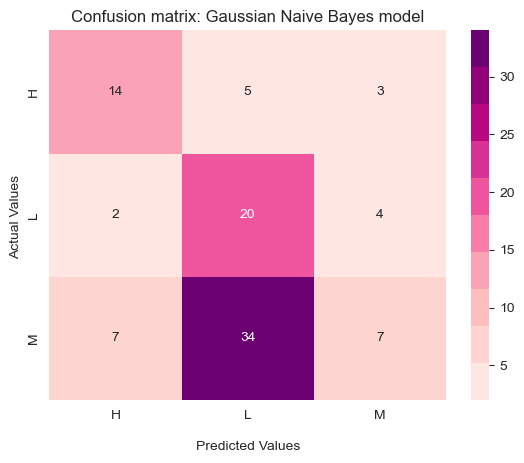

SVM
- Train Accuracy: 0.8307 
- Test  Acuuracy: 0.7917 

              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.79      0.88      0.84        26
           2       0.80      0.77      0.79        48

    accuracy                           0.79        96
   macro avg       0.79      0.79      0.79        96
weighted avg       0.79      0.79      0.79        96

#################################################################


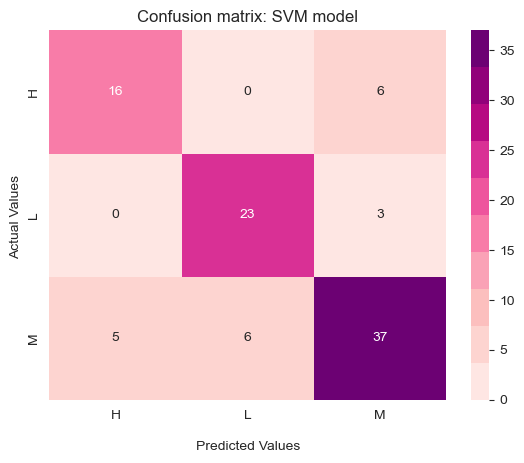

Random Forest Classifier
- Train Accuracy: 1.0000 
- Test  Acuuracy: 0.8750 

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.89      0.96      0.93        26
           2       0.88      0.88      0.88        48

    accuracy                           0.88        96
   macro avg       0.87      0.87      0.87        96
weighted avg       0.87      0.88      0.87        96

#################################################################


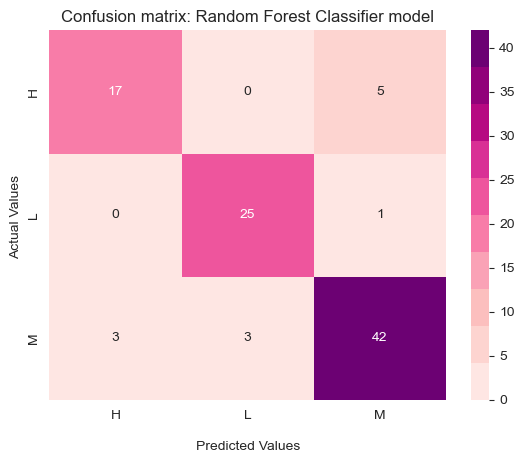

KNN
- Train Accuracy: 0.7630 
- Test  Acuuracy: 0.6458 

              precision    recall  f1-score   support

           0       0.48      0.59      0.53        22
           1       0.73      0.85      0.79        26
           2       0.69      0.56      0.62        48

    accuracy                           0.65        96
   macro avg       0.64      0.67      0.65        96
weighted avg       0.66      0.65      0.64        96

#################################################################


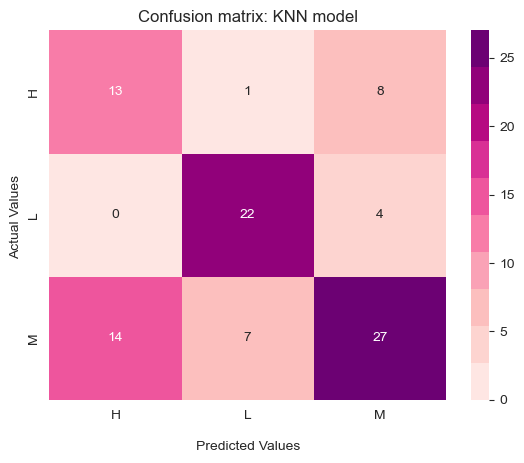

XGBoost
- Train Accuracy: 1.0000 
- Test  Acuuracy: 0.8438 

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        22
           1       0.82      0.88      0.85        26
           2       0.85      0.83      0.84        48

    accuracy                           0.84        96
   macro avg       0.84      0.85      0.84        96
weighted avg       0.84      0.84      0.84        96

#################################################################


In [31]:
models = [['Logistic Regression', LogisticRegression(multi_class='multinomial', random_state=42, max_iter=1000)],
        ['Gaussian Naive Bayes', GaussianNB()],
        ['SVM', SVC(kernel='linear', random_state=42)],
        ['Random Forest Classifier', RandomForestClassifier(random_state=42)],
        ['KNN', KNeighborsClassifier()],
        ['XGBoost', XGBClassifier()]]

models_score = []
# Select evaluation metrics
evaluation_metric = accuracy_score

for name, model in models:
    model = model
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    cm_model = confusion_matrix(y_test, model_pred)
    models_score.append(evaluation_metric(y_test, model_pred))

    print(name)
    print('- Train Accuracy: %.4f ' % evaluation_metric(y_train, model.predict(X_train)))
    print('- Test  Acuuracy: %.4f \n' % evaluation_metric(y_test, model_pred))
    print(classification_report(y_test, model_pred))
    print('#'*65)
    
    # Visualizing cm_model heatmap
    plot_cm(cm_model, title = name + " model")

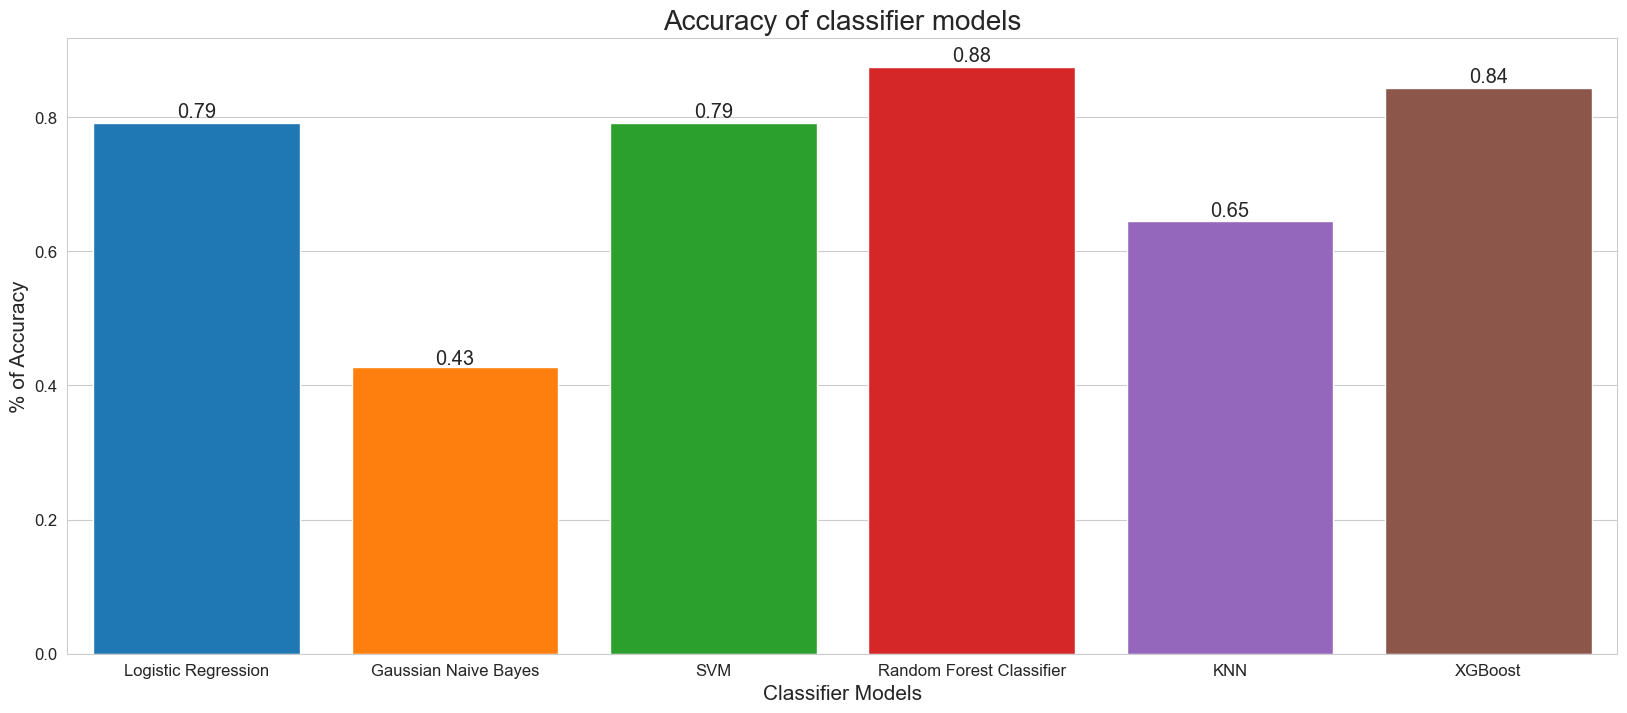

In [32]:
# Accuracy visualization
models_names = [name for name, model in models]

plt.rcParams['figure.figsize']=20,8
ax = sns.barplot(x=models_names, y=models_score, saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 15)
plt.ylabel('% of Accuracy', fontsize = 15)
plt.title('Accuracy of classifier models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)

# show values on top of barplot 
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xaxis, yaxis = i.get_xy() 
    ax.annotate(f'{round(height,2)}', (xaxis + width/2, yaxis + height*1.01), ha='center', fontsize = 'x-large')

plt.show()

Logistic Regression: 0.781242 (0.040583)
Gaussian Naive Bayes: 0.461201 (0.061544)
SVM: 0.755331 (0.049177)
Random Forest Classifier: 0.799528 (0.060699)
KNN: 0.617476 (0.046577)
XGBoost: 0.755601 (0.044564)


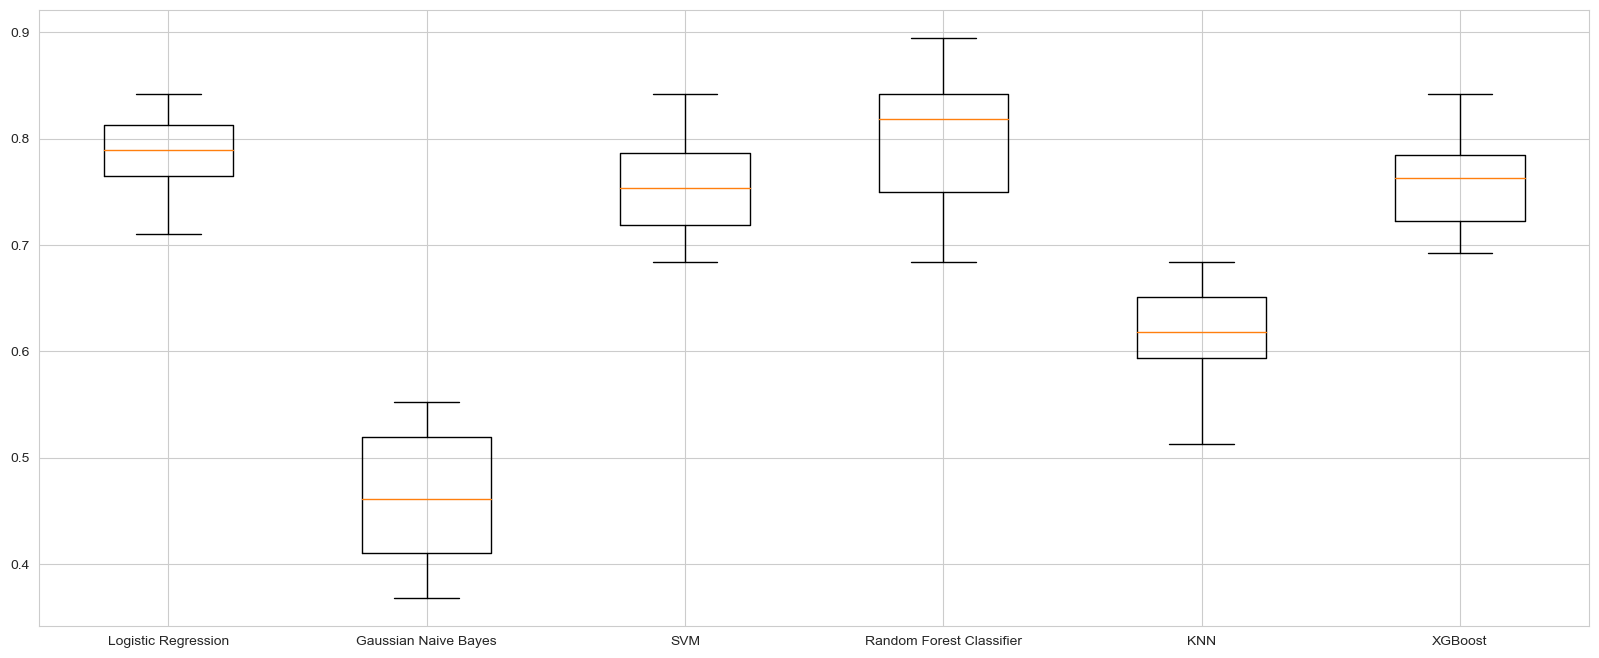

In [33]:
# K-fold score, visualization
results=[]
names=[]

for name, model in models:
    kfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' %(name,cv_results.mean(),cv_results.std()))
    
plt.boxplot(results, labels=names)
plt.show()

---

`RandomForestClassifier`

In [34]:
# Find best n_estimators
score = []
est = []
estimators = [1, 10, 50, 100, 200, 300, 400, 500]

for e in estimators:
    rfc1 = RandomForestClassifier(n_estimators=e, random_state=42)
    pred1 = rfc1.fit(X_train, y_train).predict(X_test)
    accuracy = evaluation_metric(y_test, pred1)
    score.append(accuracy)
    est.append(e)

plot = sns.pointplot(x=est, y=score)
plot.set(xlabel='Number of estimators', ylabel='Accuracy', title='Accuracy score of RFC per # of estimators')
plt.show()

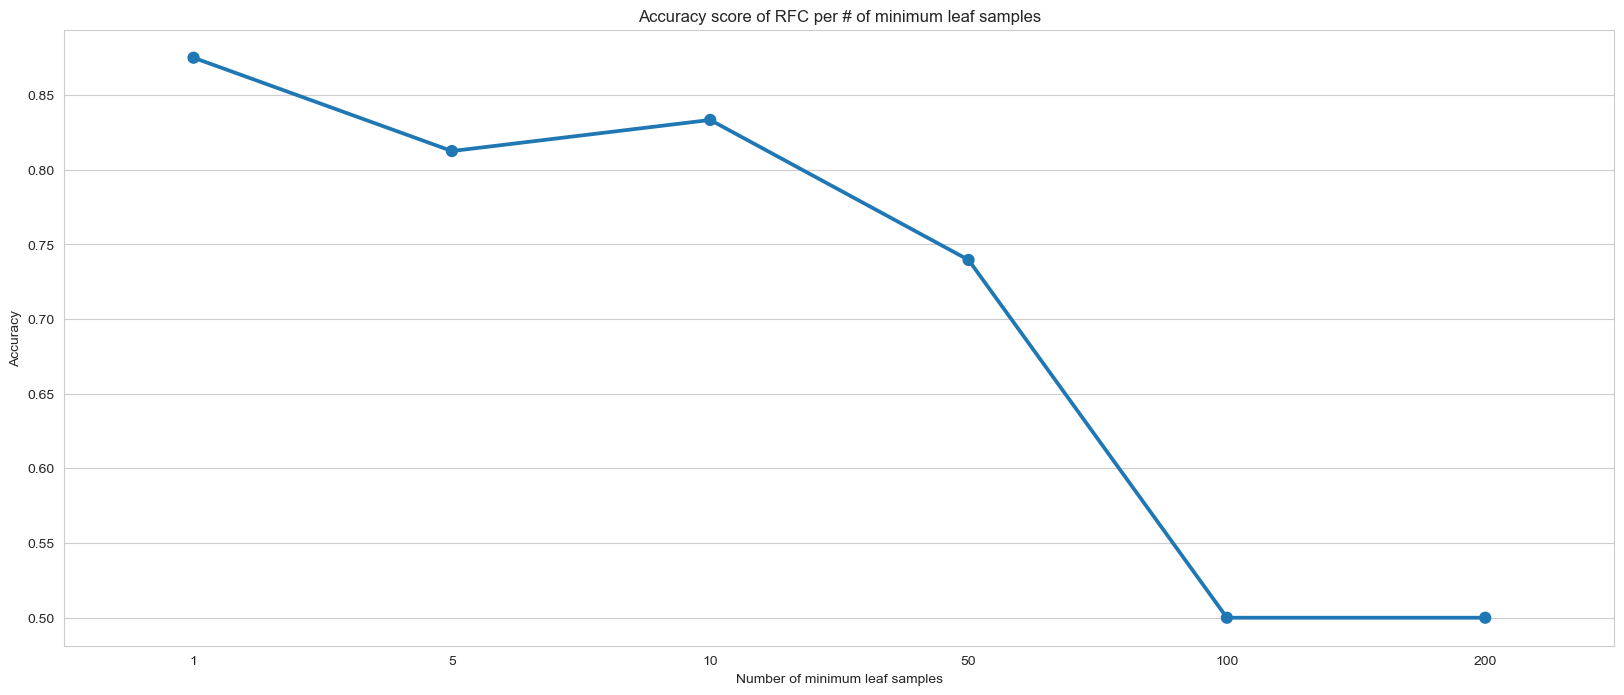

In [35]:
# Find best min_samples_leaf
score = []
leaf = []
leaf_options = [1, 5, 10, 50, 100, 200]

for l in leaf_options:
    rfc2 = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=l)
    pred2 = rfc2.fit(X_train, y_train).predict(X_test)
    accuracy = evaluation_metric(y_test, pred2)
    score.append(accuracy)
    leaf.append(l)

plot = sns.pointplot(x=leaf, y=score)
plot.set(xlabel='Number of minimum leaf samples', ylabel='Accuracy', title='Accuracy score of RFC per # of minimum leaf samples')
plt.show()

In [36]:
# Find best max_depth
score = []
depth = []
depth_options = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for d in depth_options:
    rfc3 = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=1, max_depth=d)
    pred3 = rfc3.fit(X_train, y_train).predict(X_test)
    accuracy = evaluation_metric(y_test, pred3)
    score.append(accuracy)
    depth.append(d)

plot = sns.pointplot(x=depth, y=score)
plot.set(xlabel='Number of maximum tree depth', ylabel='Accuracy', title='Accuracy score of RFC per # of maximum tree depth')
plt.show()

---
`Final model`

In [37]:
# final model training
final_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_depth=20, random_state=42)
final_model.fit(X_train, y_train)
pred = final_model.predict(X_test)
print("Accuracy: %.4f \n" % accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.8750 

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.89      0.96      0.93        26
           2       0.88      0.88      0.88        48

    accuracy                           0.88        96
   macro avg       0.87      0.87      0.87        96
weighted avg       0.87      0.88      0.87        96



In [38]:
# model feature importances visualization
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = X.columns

plt.figure(figsize=(8, 5))
plt.title("Feature importances")
plt.bar(x=range(len(indices)), height=importances[indices], color="r", align="center")
plt.xticks(ticks=range(len(indices)), labels=feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [39]:
# Visualizing Logistic Regression coefficient

# plt.figure(figsize=(10, 15))
# j = 1

# for i in [0, 1, 2]:
#     plt.subplot(3, 1, j)
#     plt.bar(X.columns, model_lr.coef_[i, :])
#     plt.xticks(rotation=90)
#     j += 1

# plt.suptitle('Logistic regression model"s coefficient', fontsize=12)
# plt.tight_layout()
# plt.show()

### Optuna

`RandomForestClassifier Parameters`

|Parameter|설명|부과설명|
|---------|----|--------|
|n_estimators|앙상블 트리의 개수(default:100)|무작정 트리 개수를 늘리면 성능 좋아지는것 대비 시간이 오래걸림|
|criterion|불순도 측도(default:gini)|'entropy'|
|max_depth|트리의 최대 깊이(default:None)|
|min_samples_splits|노드를 분할하기 위한 최소한의 샘플 데이터 수(default:2, int or float)|과적합 제어하는데 사용|
|min_samples_leaf|리프노드가 되기 위해 필요한 최소한의 샘플 데이터 수(default:1, int or float)|min_samples_split과 함께 과적합 제어 용도
|max_features|최적의 분할을 위해 고려할 최대 feature 갯수(default:'sqrt', int or float)|'sqrt', 'log2', 'None'|
|max_leaf_node|리프노드의 최대 개수(default:None)|

In [40]:
def optimizer(trial, X, y, K):
    n_estimators = trial.suggest_int("n_estimators", 50, 400) 
    max_depth = trial.suggest_int("max_depth", 5, 30) 
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt']) 
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy'])  
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  criterion=criterion,
                                  min_samples_leaf=min_samples_leaf,
                                  n_jobs=-1,
                                  random_state=42)
    

    folds = StratifiedKFold(n_splits=K)
    scores = []
    
    # validation set
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [41]:
K = 5 # K-fold
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="RF", direction="maximize")
rf_study.optimize(opt_func, n_trials=50)

In [42]:
print("Best Score: %.4f" % rf_study.best_value) 
print("Best params: ", rf_study.best_trial.params)

Best Score: 0.7943
Best params:  {'n_estimators': 207, 'max_depth': 17, 'max_features': 'auto', 'criterion': 'gini', 'min_samples_leaf': 1}


In [43]:
optuna.visualization.plot_optimization_history(rf_study)

In [44]:
optuna.visualization.plot_param_importances(rf_study)

## ROC Curve

**Plotting precision-recall curve and roc-curve of multiclass classifier**

From scikit-learn documentation:

 - **Precision-Recall**:
 
 Precision-recall curves are typically used in binary classification to study the output of a classifier. In order to extend the precision-recall curve and average precision to multi-class or multi-label classification, it is necessary to binarize the output. One curve can be drawn per label, but one can also draw a precision-recall curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).


 - **Receiver Operating Characteristic (ROC)**:
    
 ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

Therefore, you should binarize the output and consider precision-recall and roc curves for each class. Moreover, you are going to use predict_proba to get class probabilities.

--- 

Precision-Recall : https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

ROC : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

---
Divide the code into three parts.
1. general settings, learning and prediction
2. precision-recall curve
3. ROC curve

In [45]:
n_classes = len(set(y)) # 타겟 개수

# 일대 다 방식으로 레이블을 이진화
# 클래스별로 배열을 따로 만들어서 해당 클래스의 값이면 1, 아니면 0으로 표시
binarize_y = label_binarize(y, classes=[*range(n_classes)]) 

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, binarize_y, test_size=0.2, random_state=42)

# 타깃 레이블의 개수 만큼 트리 계열 모델을 만들어 각 레이블을 타깃으로 하는 분류기를 학습
clf = OneVsRestClassifier(RandomForestClassifier(random_state=24))
clf.fit(X_train_temp, y_train_temp)

y_score = clf.predict_proba(X_test_temp) # 각 클래스에 대한 확률

ROC curve
- x축을 (1-특이도, 실제 음성인 것 중 양성으로 잘못 예측한 것의 비율)로 y축을 민감도(실제 양성인 것 중 양성으로 잘 예측한 것의 비율)로 그린 그림
    
    즉 실제 음성인데 양성으로 잘못 예측한 경우가 적고(1-특이도가 작고), 실제 양성을 양성으로 잘 예측한 경우가 많으면(민감도가 높을수록) 좋은 모델(그래프의 왼쪽 위)


Text(0.5, 1.0, 'ROC curve')

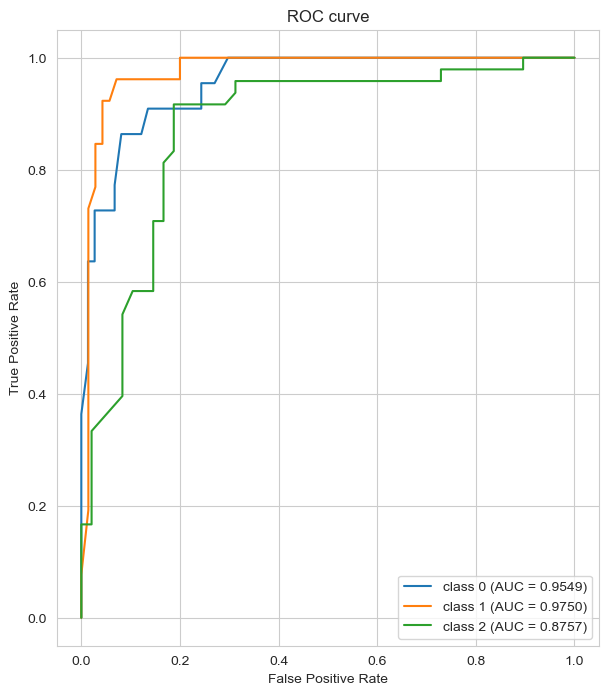

In [46]:
fpr = dict()
tpr = dict()

_, ax = plt.subplots(figsize=(7, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_temp[:, i], y_score[:, i]) # return: fpr, tpr, thresholds
    
    display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i])
    display.plot(ax=ax, name=f'class {i} (AUC = {auc(fpr[i], tpr[i]):.4f})')
    
display.ax_.set_title("ROC curve")

PR(Precision Recall) curve (정밀도-재현율 곡선)
- 정밀도와 재현율 모두 높을수록(그래프의 오른쪽 위) 좋은 모델

In [47]:
precision = dict()
recall = dict()
average_precision = dict()

_, ax = plt.subplots(figsize=(7, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_temp[:, i], y_score[:, i]) # return: precision, recall, thresholds
    average_precision[i] = average_precision_score(y_test_temp[:, i], y_score[:, i])
    
    display = PrecisionRecallDisplay(recall=recall[i], precision=precision[i], average_precision=average_precision[i])
    display.plot(ax=ax, name=f"class {i}")
    
display.ax_.set_title("PR curve")

Text(0.5, 1.0, 'PR curve')